In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulate as sim

In [2]:
#starting with an [r,t,n] 
center_of_mass = np.array([[0,0,0]]).T
orbit_radius = 10

sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nx0 = sat1_x0/np.linalg.norm(sat1_x0)
sat1_v = 3 #u/s
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1]))

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nx0 = sat2_x0/np.linalg.norm(sat2_x0)
sat2_v = 3 #u/s
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1]))

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nx0 = sat3_x0/np.linalg.norm(sat3_x0)
sat3_v = 3 #u/s
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0]))



del_t = 0.1 #arbitrary time unit
n_orbits = 0.1
t = np.linspace(0,n_orbits*2*np.pi)
x1 = center_of_mass + orbit_radius * np.sin(t) * sat1_nv0 + orbit_radius * np.cos(t) * sat1_nx0
x2 = center_of_mass + orbit_radius * np.sin(t) * sat2_nv0 + orbit_radius * np.cos(t) * sat2_nx0
x3 = center_of_mass + orbit_radius * np.sin(t) * sat3_nv0 + orbit_radius * np.cos(t) * sat3_nx0



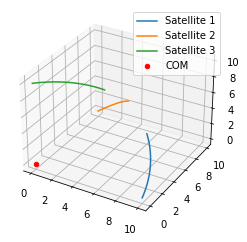

In [3]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(0,0,0,color='r',label="COM")

ax.plot(x1[0,:],x1[1,:],x1[2,:], label='Satellite 1')
ax.plot(x2[0,:],x2[1,:],x2[2,:], label='Satellite 2')
ax.plot(x3[0,:],x3[1,:],x3[2,:], label='Satellite 3')
ax.legend()
#ax.axis("equal")

plt.show()


In [4]:
orbit_radius = 10
sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1])).T

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1])).T

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0])).T

# Initialize 3 Observer Satellites
o1 = sim.observer(sat1_x0,sat1_nv0)
o2 = sim.observer(sat2_x0,sat2_nv0)
o3 = sim.observer(sat3_x0,sat3_nv0)

In [5]:
debris_points = np.array([[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1],[-1,1,1],[-1,1,-1],[-1,-1,1],[-1,-1,-1],[3,0,1],[3,0,-1],[-2,0,-1]]).T
    
    # Initialize the Quaternion for Debris Rotation. 
    # Given any normalized direction vector [nx,ny,nz] and angular rotation [omega], the quaternion is of the 
    # form: [nx*sin(omega/2),ny*sin(omega/2),nz*sin(omega/2),cos(omega/2)]
omega = .04 # rad/s
quat = np.array([0,1*np.sin(omega/2),0,np.cos(omega/2)])

# Initialize the Debris Object
deb = sim.debris(debris_points,quat)
mtest = sim.MeasurementModel(deb,np.array([o1,o2,o3]),n_blind=0)

In [6]:
import EKF_class as EKF
n = 36
mu0 = np.zeros((n))
mu0[:3] = np.array([0.01, 0.01, 0.01])
mu0[3:] = debris_points.flatten()
sigma0 = 100* np.diag(np.ones((n)))

kalman_filter = EKF.KalmanFilter(mu0, sigma0, del_t)

In [7]:
t1 = np.linspace(0,60, int(60/del_t))

P_est_hist = np.zeros((len(t1), n, n))
x_est_hist = np.zeros((len(t1), n))
x_est_hist_min = np.zeros((len(t1), n))
for i in range(len(t1)):
    y = mtest[i].flatten() #replace with measurements
    sat_pos = o1[i].flatten()

    x_est_min, P_est = kalman_filter.predict()
    x_est, P_est = kalman_filter.update(y[:11], x_est_min, P_est, sat_pos)
  
    # Make sure to store the estimated state and covariance for analysis
    P_est_hist[i, :, :] = P_est
    x_est_hist[i, :] = x_est
    x_est_hist_min[i, :] = x_est_min

C [-0.76176396 -0.77493568  1.82254666 -2.20181911 -0.77493568 -0.75737339
  1.          0.20793098 -0.77932625  1.18118722 -0.77493568]
[ 0.          0.         -2.33508956  1.76196435  1.98010293  1.98010293
  0.09053651  0.99103157 -2.03936577 -4.01946869  2.931161  ]
C [-1.21560106 -0.22808405 -0.80038484 -0.30426339  1.49374925  1.14228627
  1.03247426  1.16542354 -2.56953545 -2.35890495  2.33021617]
[-0.04171159 -0.12892638 -0.08013592  0.24678594 -0.17206452  0.18630711
 -0.02220287  0.24080438 -0.32826529 -0.18296485  0.1753176 ]
C [-1.59886434  0.24547847 -1.34939155  0.33634897  1.67675884  1.33340264
  0.87742219  1.34535629 -2.41086904 -1.97237368  2.70431853]
[ 1.86529470e-01 -4.98771159e-01  4.50558452e-01 -2.65293678e-02
 -6.90886617e-01  3.57095445e-04  1.39197854e-02  1.92607784e-01
 -3.16381730e-01 -3.09896368e-02 -2.84065658e-01]
C [-1.61973375  0.13041944 -1.2096807   0.58441363  1.30648478  1.32232126
  0.79449194  1.46034464 -2.31337598 -1.5226406   2.58225282]
[ 

## Angular Velocity

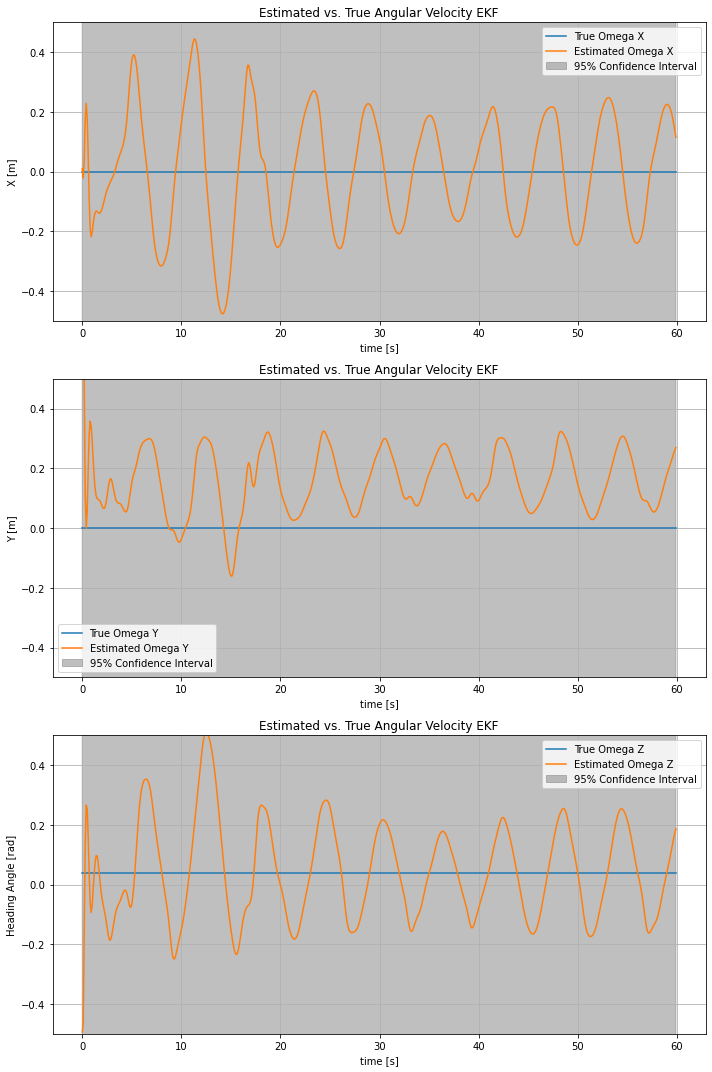

In [8]:
time_step = del_t
time_array = np.arange(0, len(x_est_hist) * time_step, time_step)

std_dev_heading = np.sqrt(P_est_hist[:, 5, 5])
confidence_interval_heading = 1.96 * std_dev_heading #95%

std_dev_x = np.sqrt(P_est_hist[:, 3, 3])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, 4, 4])
confidence_interval_y = 1.96 * std_dev_y

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(time_array,  np.zeros(len(time_array)), label="True Omega X")
axs[0].plot(time_array, x_est_hist[:, 0], label="Estimated Omega X")
axs[0].fill_between(time_array, x_est_hist[:, 0] - confidence_interval_x, x_est_hist[:, 0] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('X [m]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_ylim([-0.5, 0.5])
axs[0].set_title('Estimated vs. True Angular Velocity EKF')

# Plot Y Position
axs[1].plot(time_array, np.zeros(len(time_array)), label="True Omega Y")
axs[1].plot(time_array, x_est_hist[:, 1], label="Estimated Omega Y")
axs[1].fill_between(time_array,  x_est_hist[:, 1] - confidence_interval_y, x_est_hist[:, 1] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim([-0.5, 0.5])
axs[1].set_title('Estimated vs. True Angular Velocity EKF')

axs[2].plot(time_array,  omega * np.ones(len(time_array)), label="True Omega Z")
axs[2].plot(time_array, x_est_hist[:, 2], label="Estimated Omega Z")
axs[2].fill_between(time_array, x_est_hist[:, 2] - confidence_interval_heading, x_est_hist[:, 2] + confidence_interval_heading, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('Heading Angle [rad]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Estimated vs. True Angular Velocity EKF')
axs[2].set_ylim([-0.5, 0.5])

plt.tight_layout()
plt.show()




In [9]:
posehist = np.zeros((3, len(time_array)))

for t in range(len(time_array)):
    debr = deb[t].flatten()
    print(debr[3:6])
    posehist[:, t] = debr[3:6]

posehist = posehist.T

[ 1. -1. -1.]
[ 0.95921077 -0.95921077 -1.03918944]
[ 0.91688701 -0.91688701 -1.0767164 ]
[ 0.87309643 -0.87309643 -1.11252084]
[ 0.82790908 -0.82790908 -1.14654549]
[ 0.78139725 -0.78139725 -1.17873591]
[ 0.73363535 -0.73363535 -1.2090406 ]
[ 0.68469979 -0.68469979 -1.23741109]
[ 0.63466886 -0.63466886 -1.26380198]
[ 0.58362259 -0.58362259 -1.28817106]
[ 0.53164265 -0.53164265 -1.31047934]
[ 0.4788122  -0.4788122  -1.33069113]
[ 0.42521575 -0.42521575 -1.3487741 ]
[ 0.37093904 -0.37093904 -1.36469932]
[ 0.31606891 -0.31606891 -1.37844131]
[ 0.26069314 -0.26069314 -1.38997809]
[ 0.20490032 -0.20490032 -1.3992912 ]
[ 0.14877969 -0.14877969 -1.40636574]
[ 0.09242106 -0.09242106 -1.4111904 ]
[ 0.03591457 -0.03591457 -1.41375746]
[-0.02064938  0.02064938 -1.4140628 ]
[-0.07718029  0.07718029 -1.41210595]
[-0.13358773  0.13358773 -1.40789002]
[-0.18978146  0.18978146 -1.40142178]
[-0.24567158  0.24567158 -1.39271155]
[-0.30116868  0.30116868 -1.38177329]
[-0.35618397  0.35618397 -1.36862448

In [10]:
print(x_est_hist_min[0, 9:12])
print(x_est_hist[0, 9:12])
print([posehist[1, :]])
print([mu0[9:12]])

[-0.986 -1.014  3.   ]
[ 1.10483399 -0.78934718  2.57295366]
[array([ 0.95921077, -0.95921077, -1.03918944])]
[array([-1., -1.,  3.])]


## Estimate Point 3

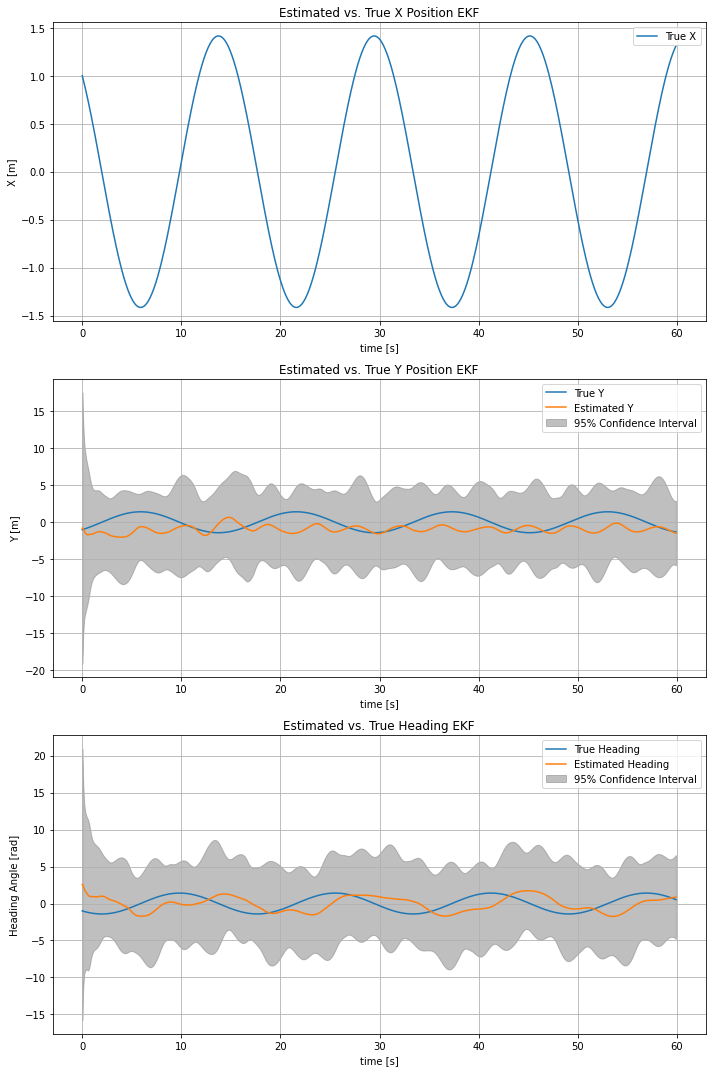

In [11]:
time_step = del_t
time_array = np.arange(0, len(x_est_hist) * time_step, time_step)

std_dev_heading = np.sqrt(P_est_hist[:, 2, 2])
confidence_interval_heading = 1.96 * std_dev_heading #95%

std_dev_x = np.sqrt(P_est_hist[:, 0, 0])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, 1, 1])
confidence_interval_y = 1.96 * std_dev_y

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(time_array, posehist[:, 0], label="True X")
#axs[0].plot(time_array, x_est_hist[:, 9], label="Estimated X")
#axs[0].fill_between(time_array, x_est_hist[:,9] - confidence_interval_x, x_est_hist[:, 9] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('X [m]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Estimated vs. True X Position EKF')

# Plot Y Position
axs[1].plot(time_array, posehist[:, 1], label="True Y")
axs[1].plot(time_array, x_est_hist[:, 10], label="Estimated Y")
axs[1].fill_between(time_array,  x_est_hist[:, 10] - confidence_interval_y, x_est_hist[:, 10] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Estimated vs. True Y Position EKF')

axs[2].plot(time_array, posehist[:, 2], label="True Heading")
axs[2].plot(time_array, x_est_hist[:, 11], label="Estimated Heading")
axs[2].fill_between(time_array, x_est_hist[:, 11] - confidence_interval_heading, x_est_hist[:, 11] + confidence_interval_heading, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('Heading Angle [rad]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Estimated vs. True Heading EKF')

plt.tight_layout()
plt.show()


